In [1]:
import networkx as nx
import os
import re

print(os.getcwd())

# 读取 GraphML
file_path = r"data/dataset/CSV_adjacency_list/total.graphml"
G = nx.read_graphml(file_path)

# 1️⃣ 解析所有子图（按连通分量拆分）
subgraphs = [
    G.subgraph(c).copy()
    for c in nx.weakly_connected_components(G)
    if G.subgraph(c).number_of_edges() > 0
]

# 2️⃣ 输出因果句子形式的邻接表
for i, subG in enumerate(subgraphs, start=1):
    print(f"\n--- Graph {i} ---")
    for node in subG.nodes():
        from_label = subG.nodes[node].get("label", "").strip() or node
        for neighbor in subG.successors(node):
            to_label = subG.nodes[neighbor].get("label", "").strip() or neighbor
            print(f"{from_label} causes {to_label}")


/home/chenyangtamu/graphdecoder/graphtoseq_3_nodes_no_equipment

--- Graph 1 ---
High vaporization causes Vapor cloud formation
Pre-mixture causes Vapor cloud formation
Liquid causes High vaporization
Continuous release causes Vapor cloud formation
Vapor cloud formation causes VCE
Mechanical Failure causes Continuous release
Chemical combustible causes Delayed Ignition
High confinement causes VCE
Delayed Ignition causes VCE

--- Graph 2 ---
Continuous release causes Vapor cloud formation
High confinement causes VCE
Delayed Ignition causes VCE
Pre-mixture causes Vapor cloud formation
Vapor causes Vapor cloud formation
Chemical combustible causes Delayed Ignition
Vapor cloud formation causes VCE
Mechanical Failure causes Continuous release

--- Graph 3 ---
Vapor cloud formation causes VCE
Liquid causes High vaporization
High confinement causes VCE
Mechanical Failure causes Instant release
Instant release causes Vapor cloud formation
Chemical combustible causes Delayed Ignition
High vapor

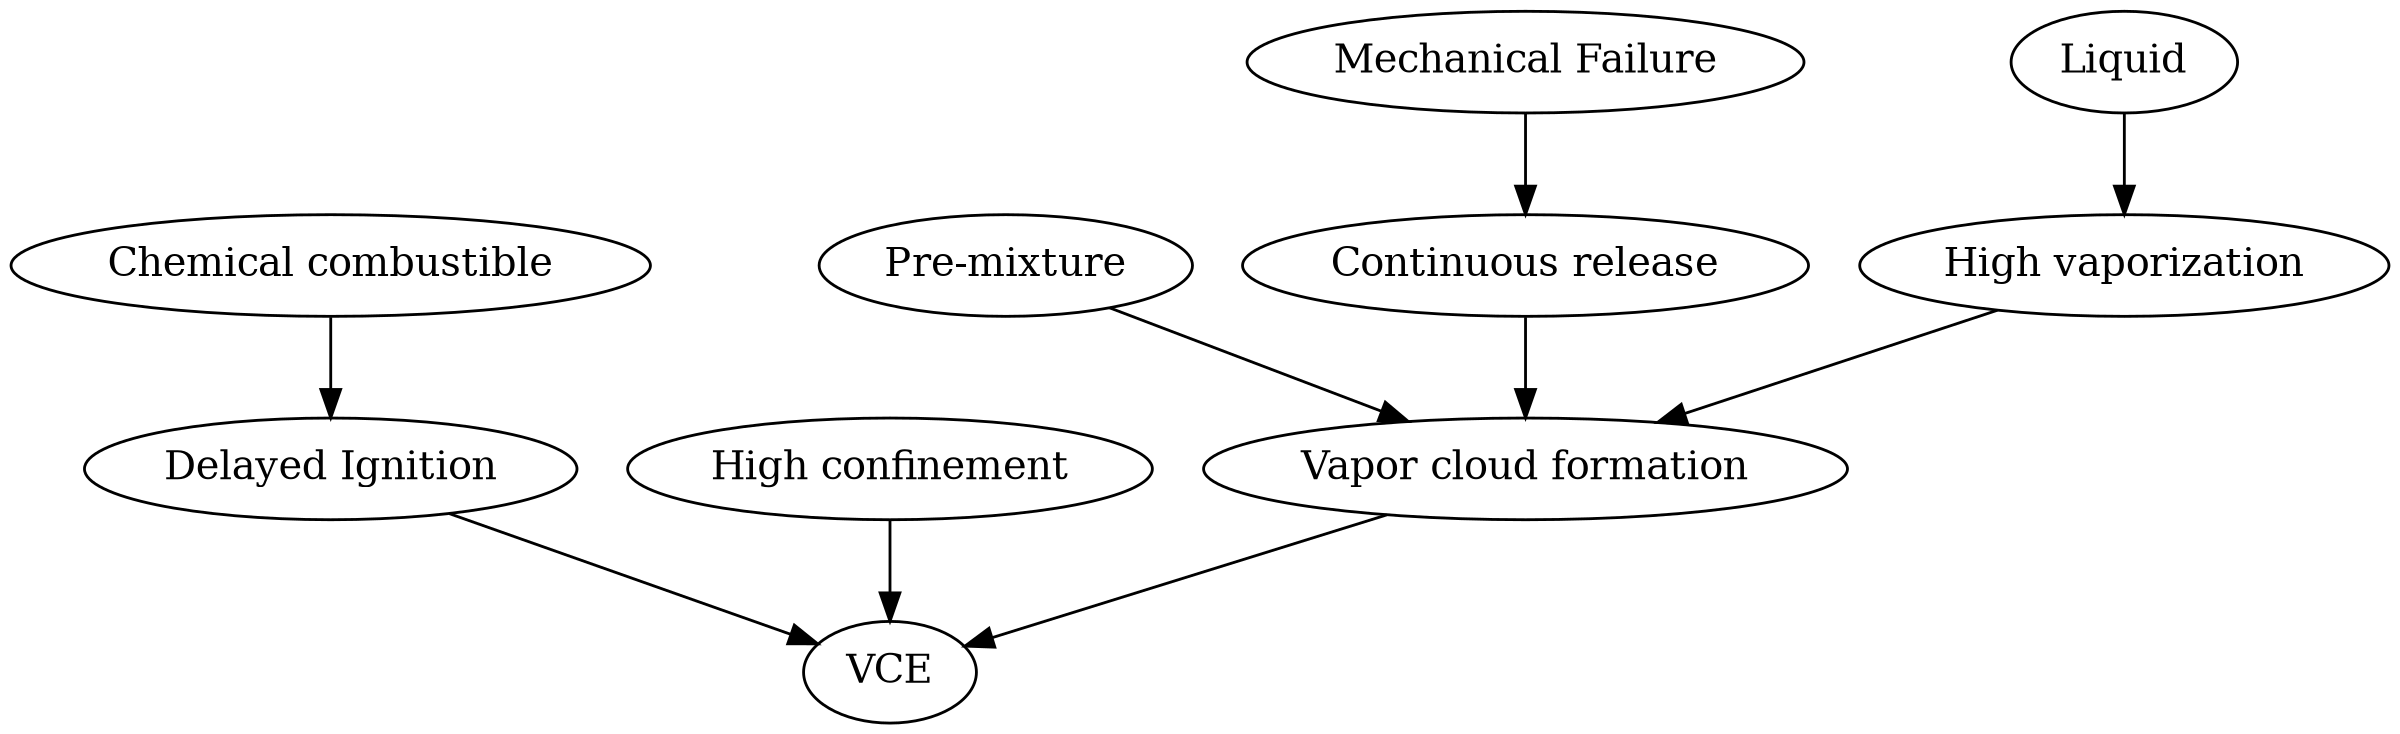

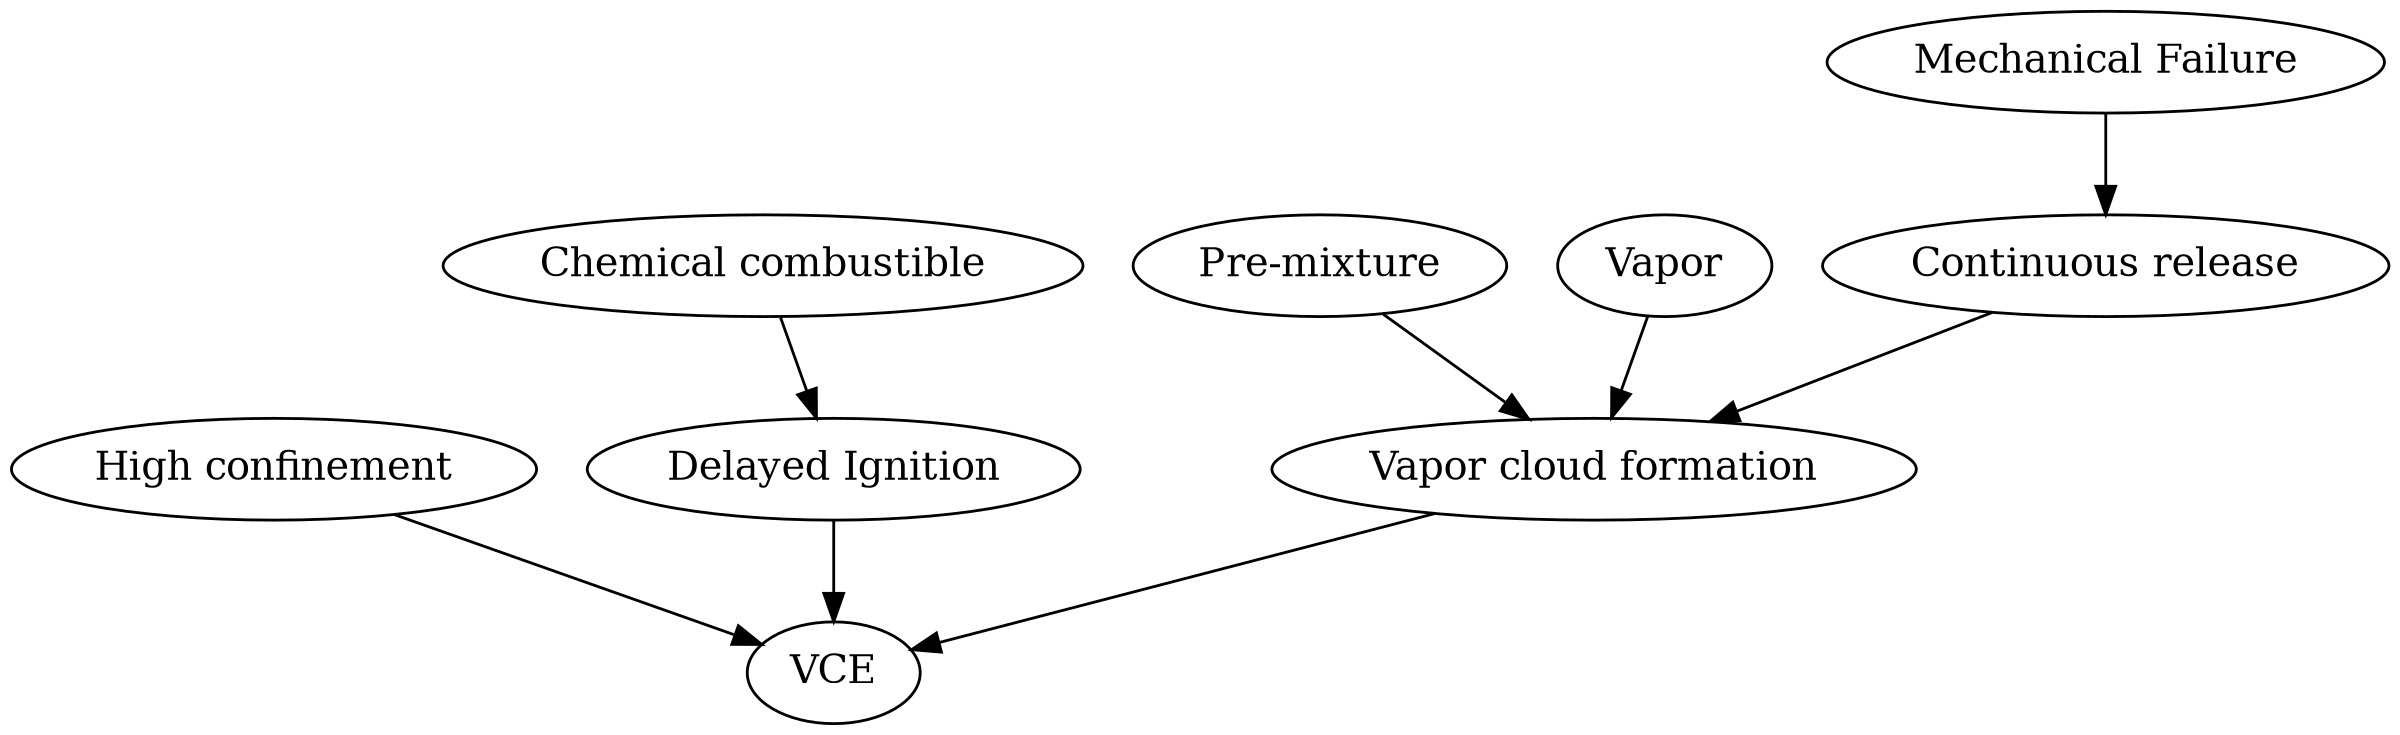

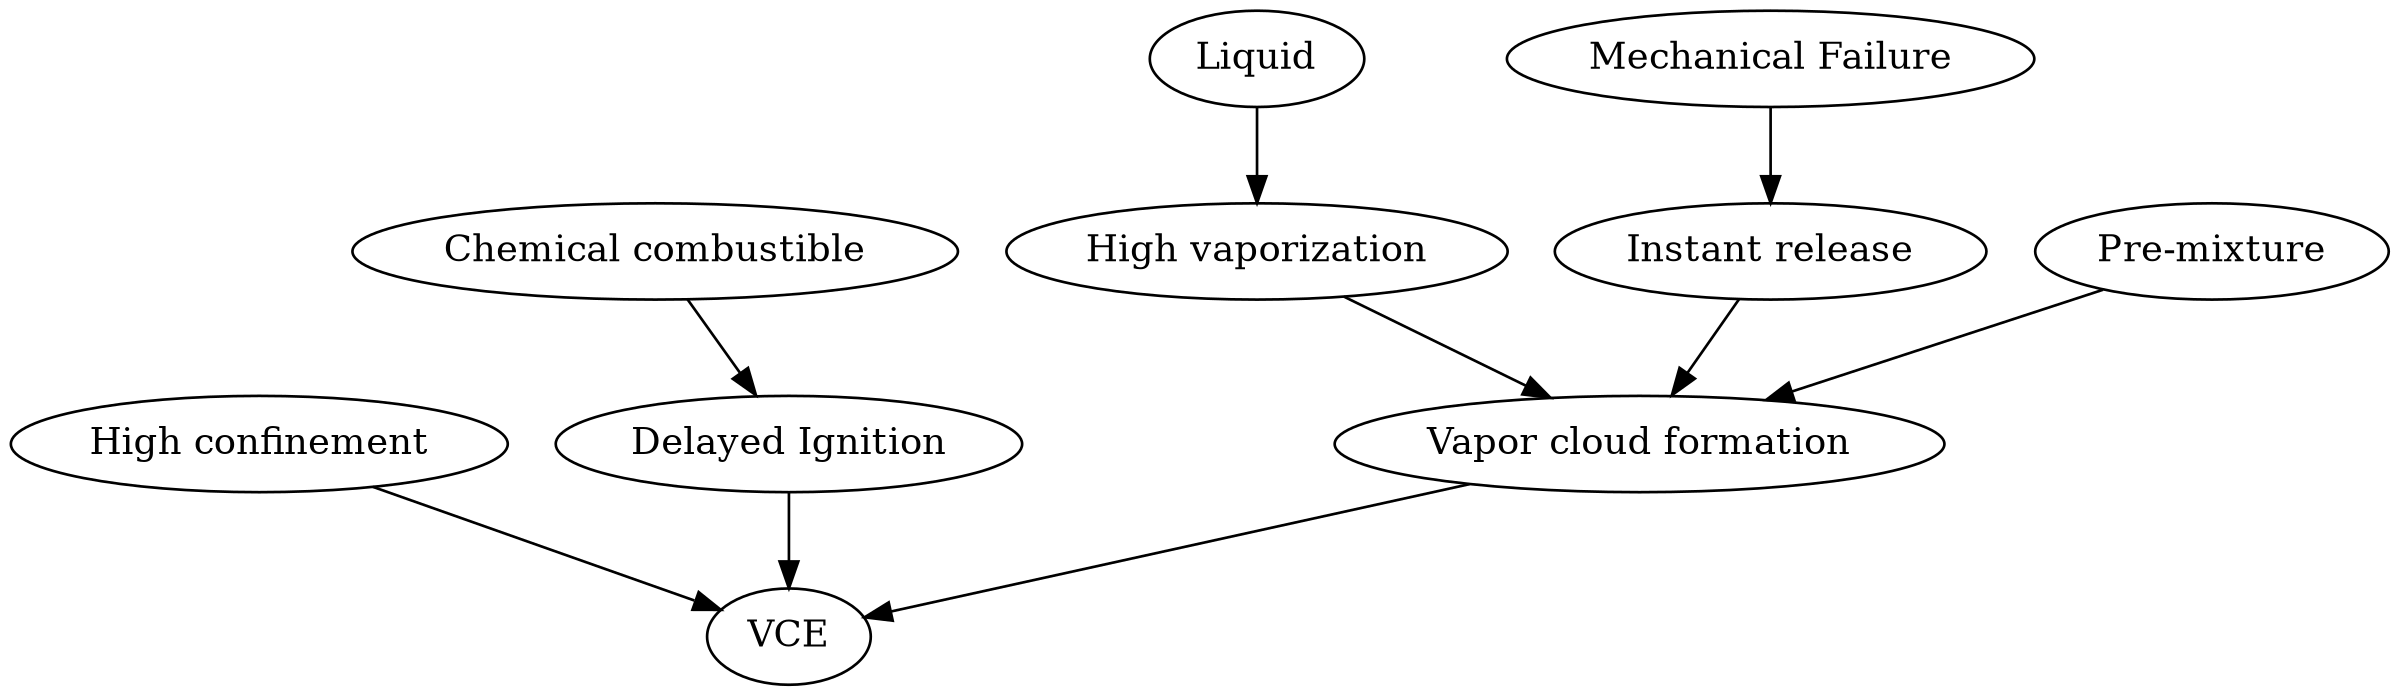

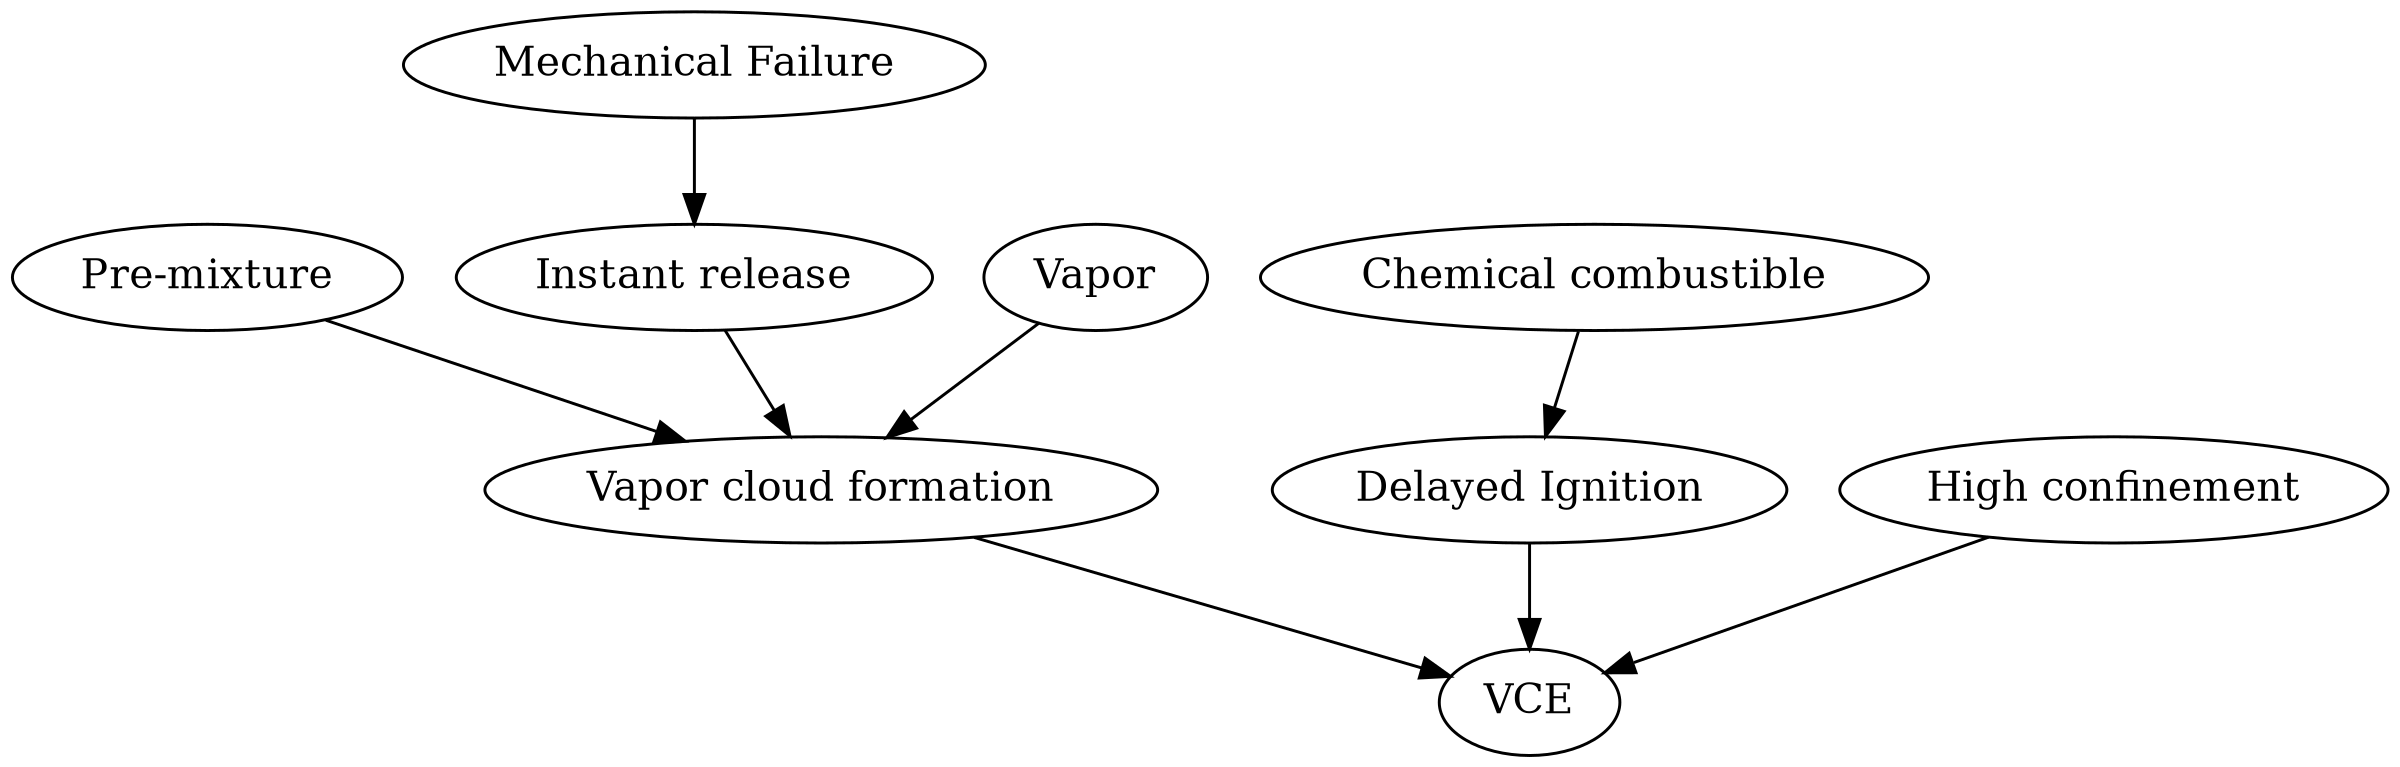

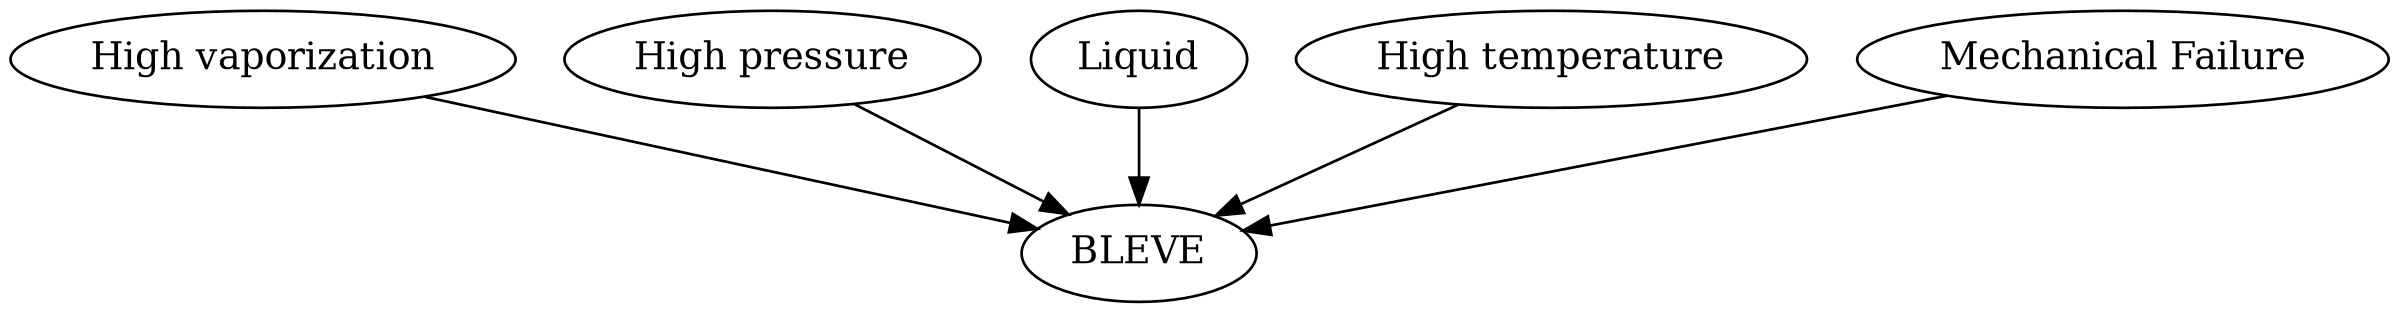

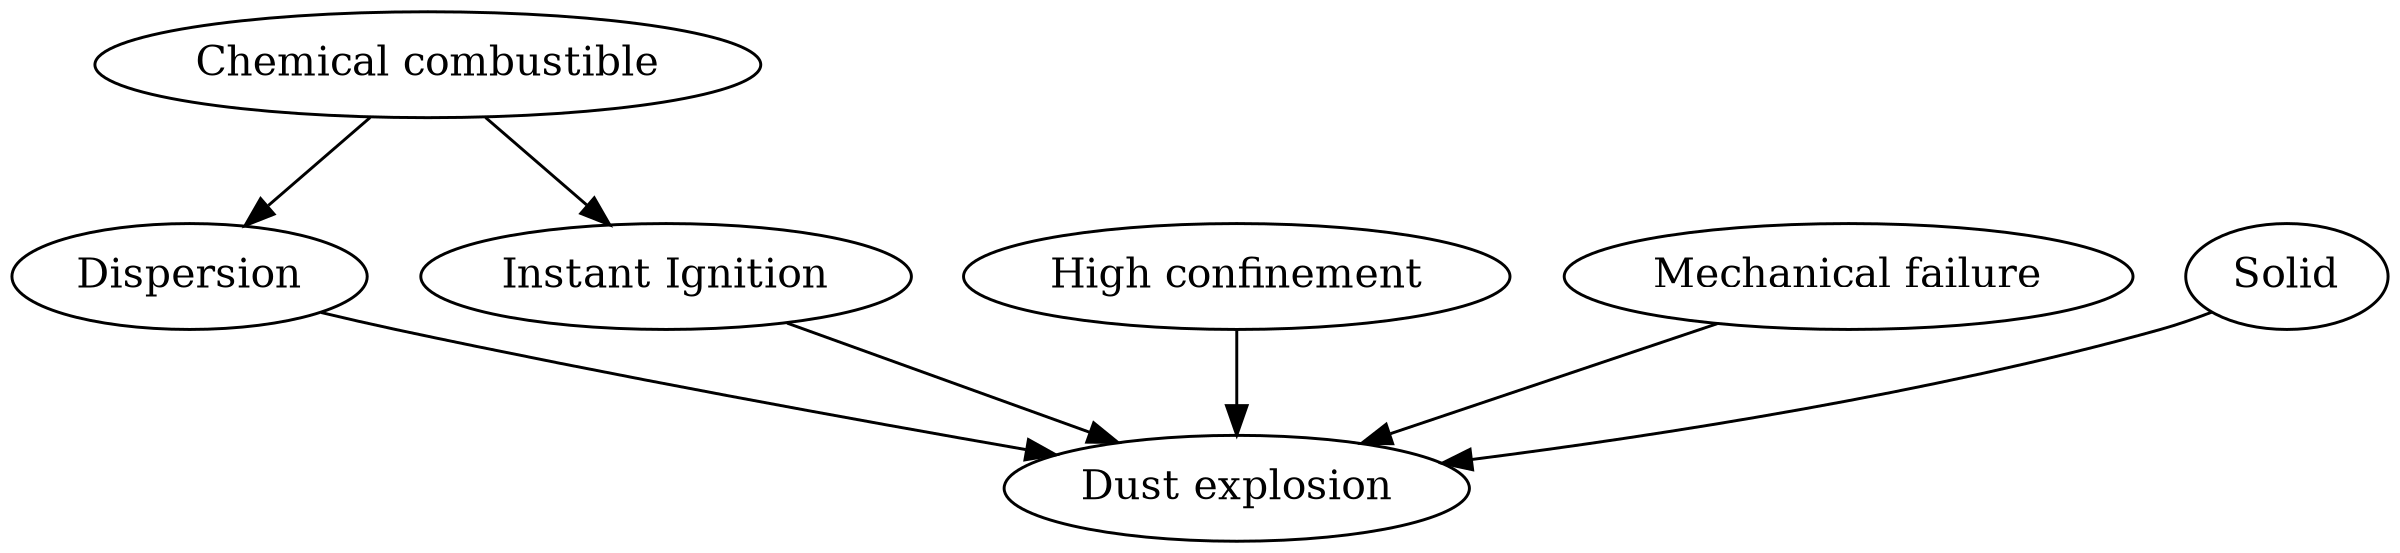

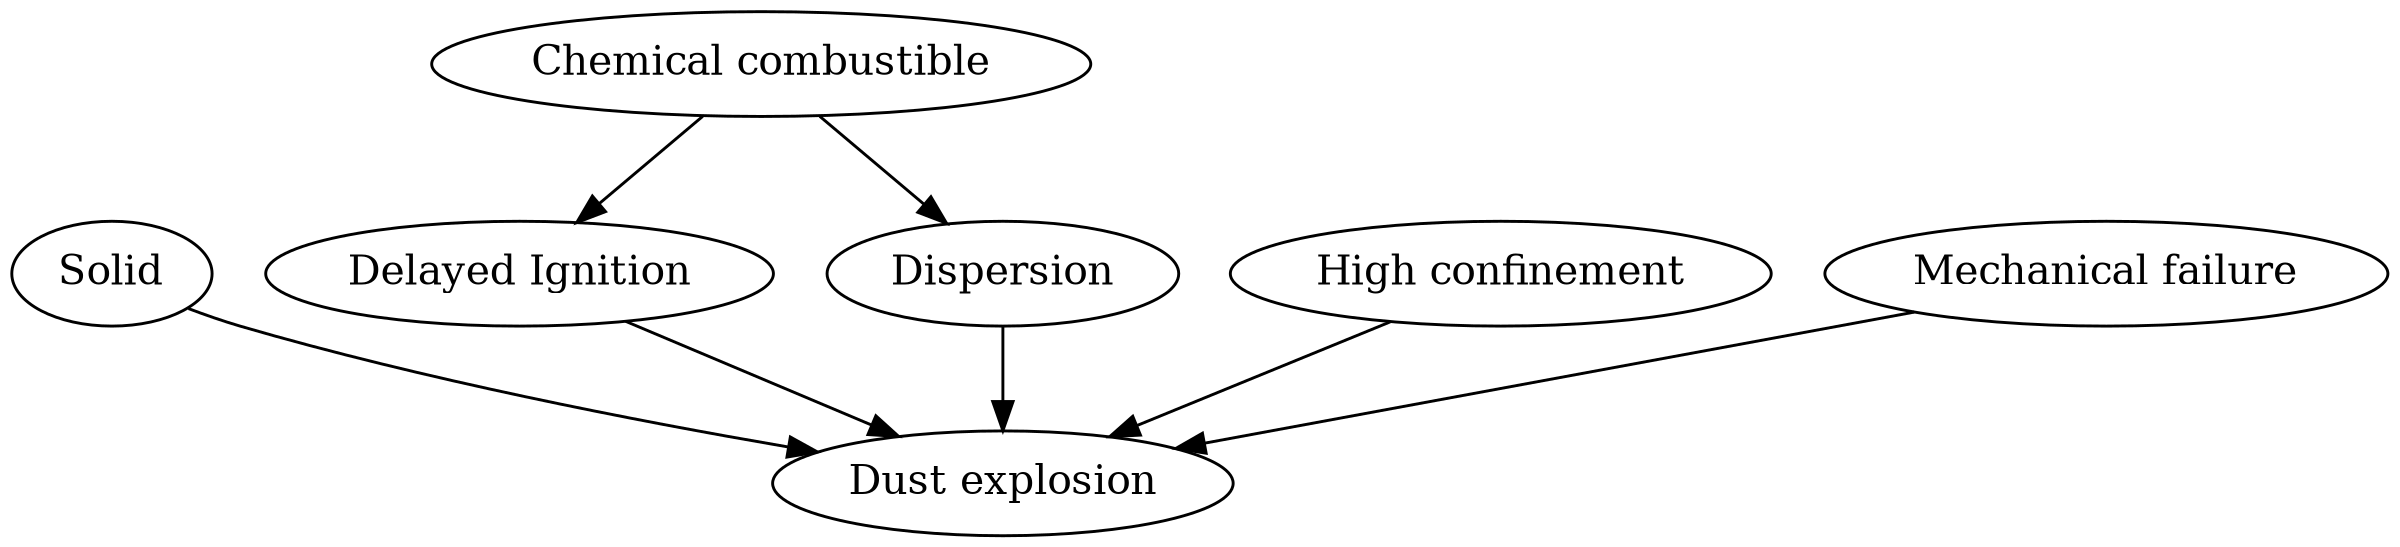

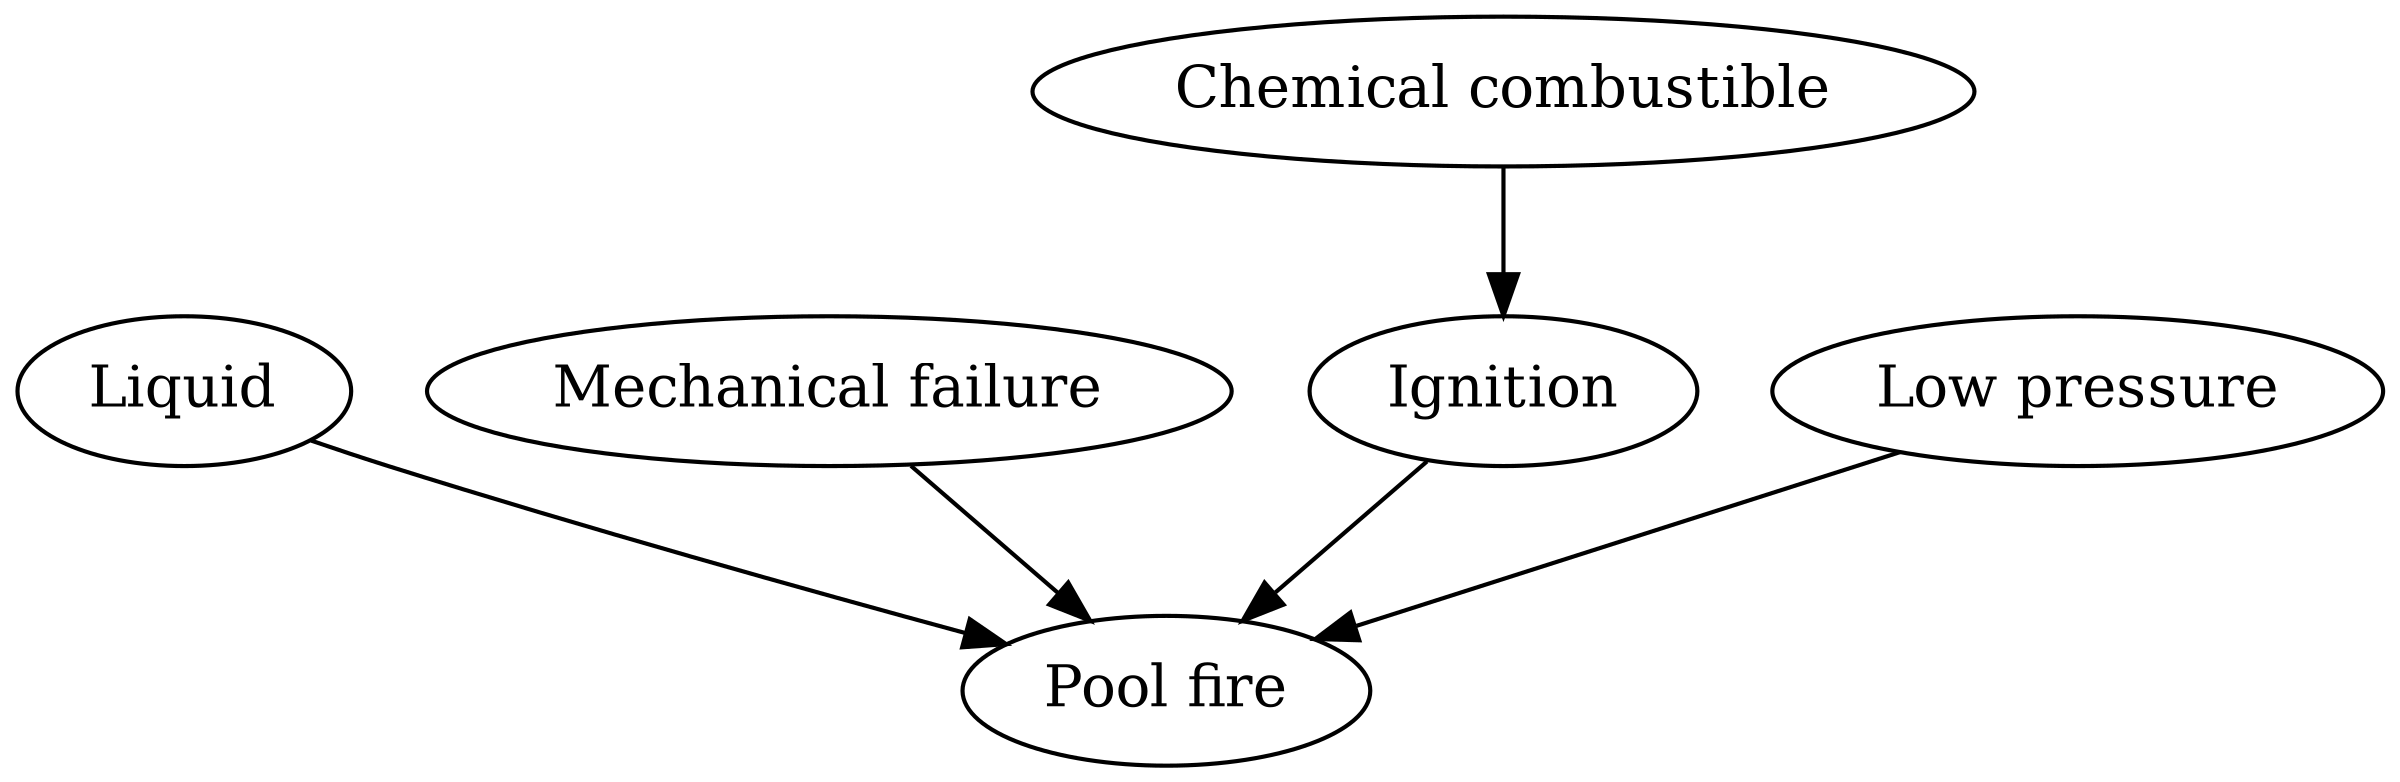

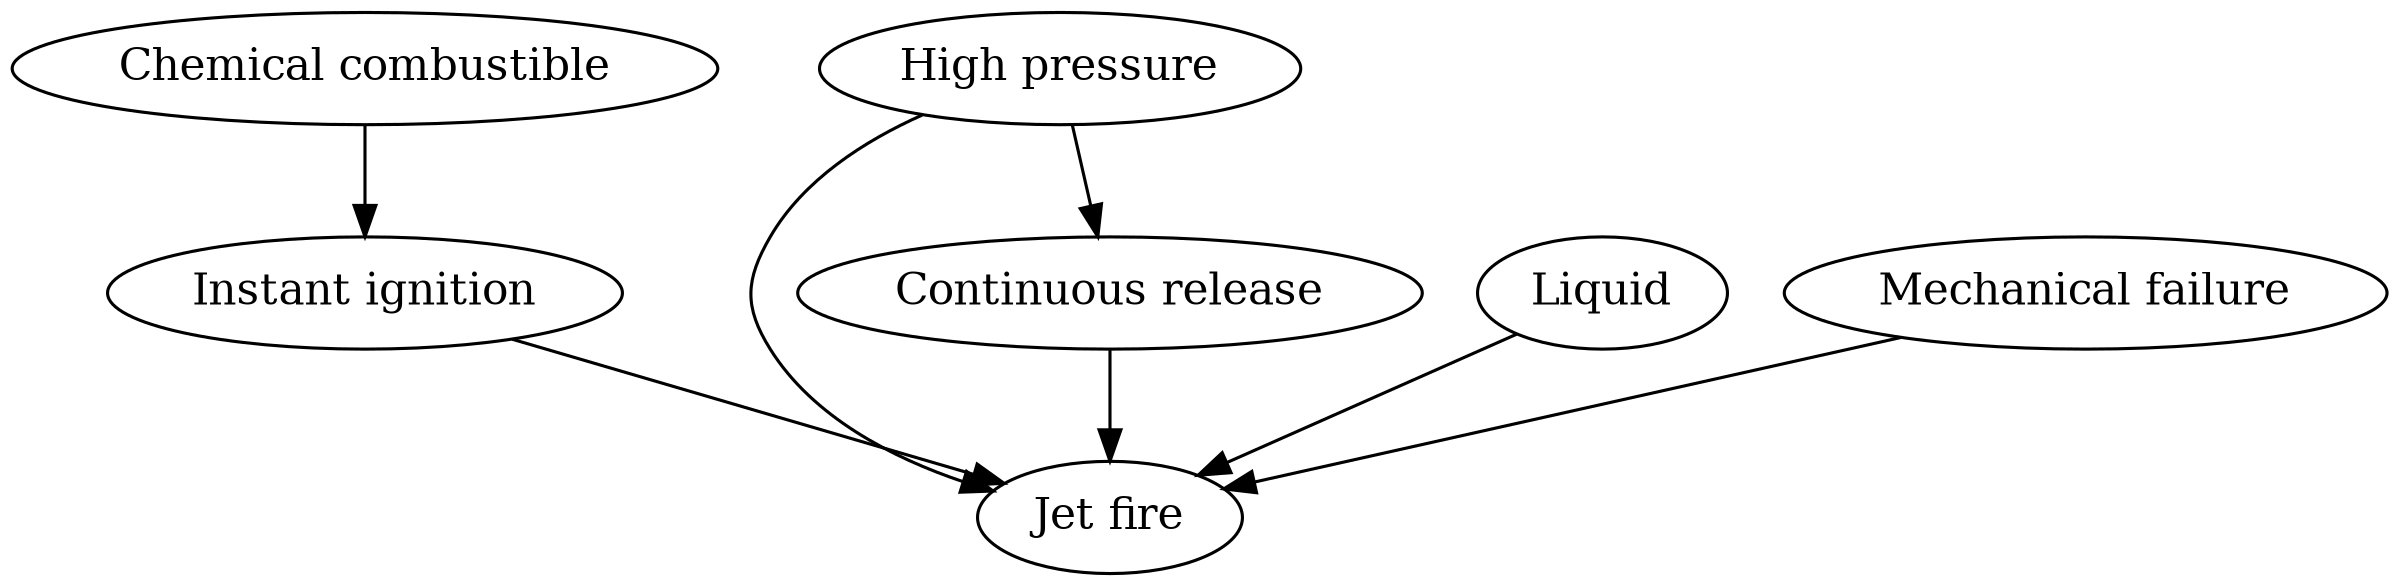

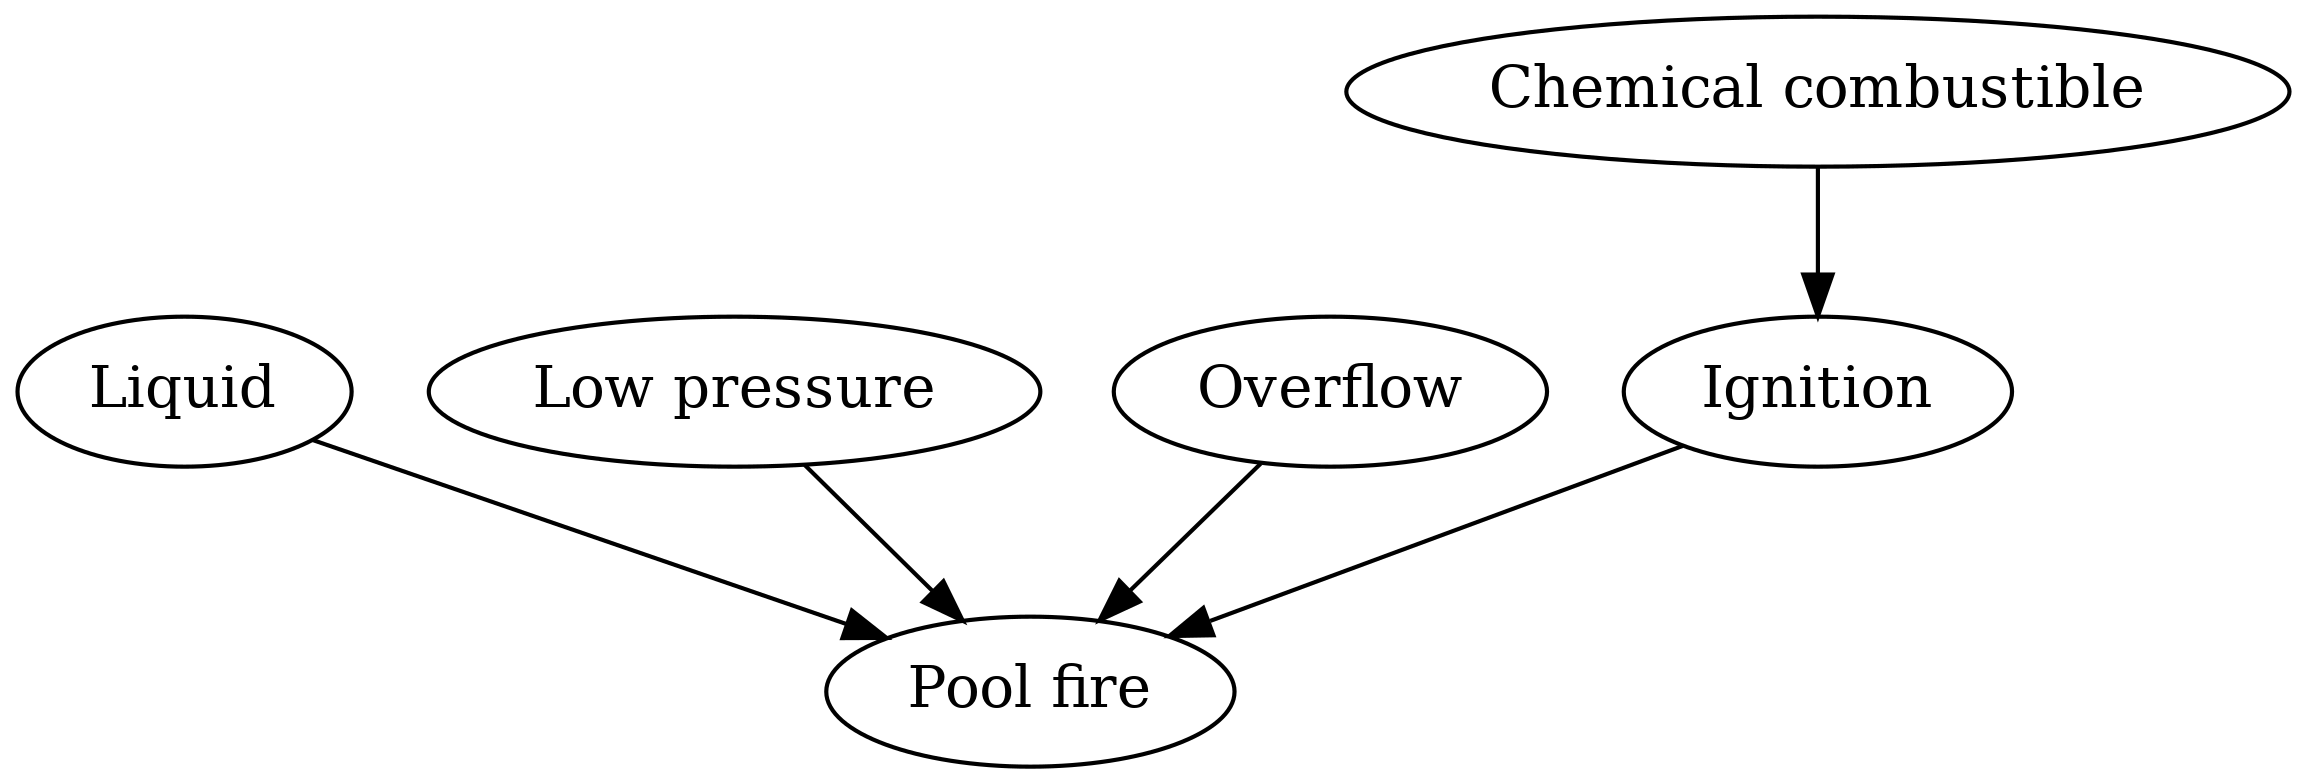

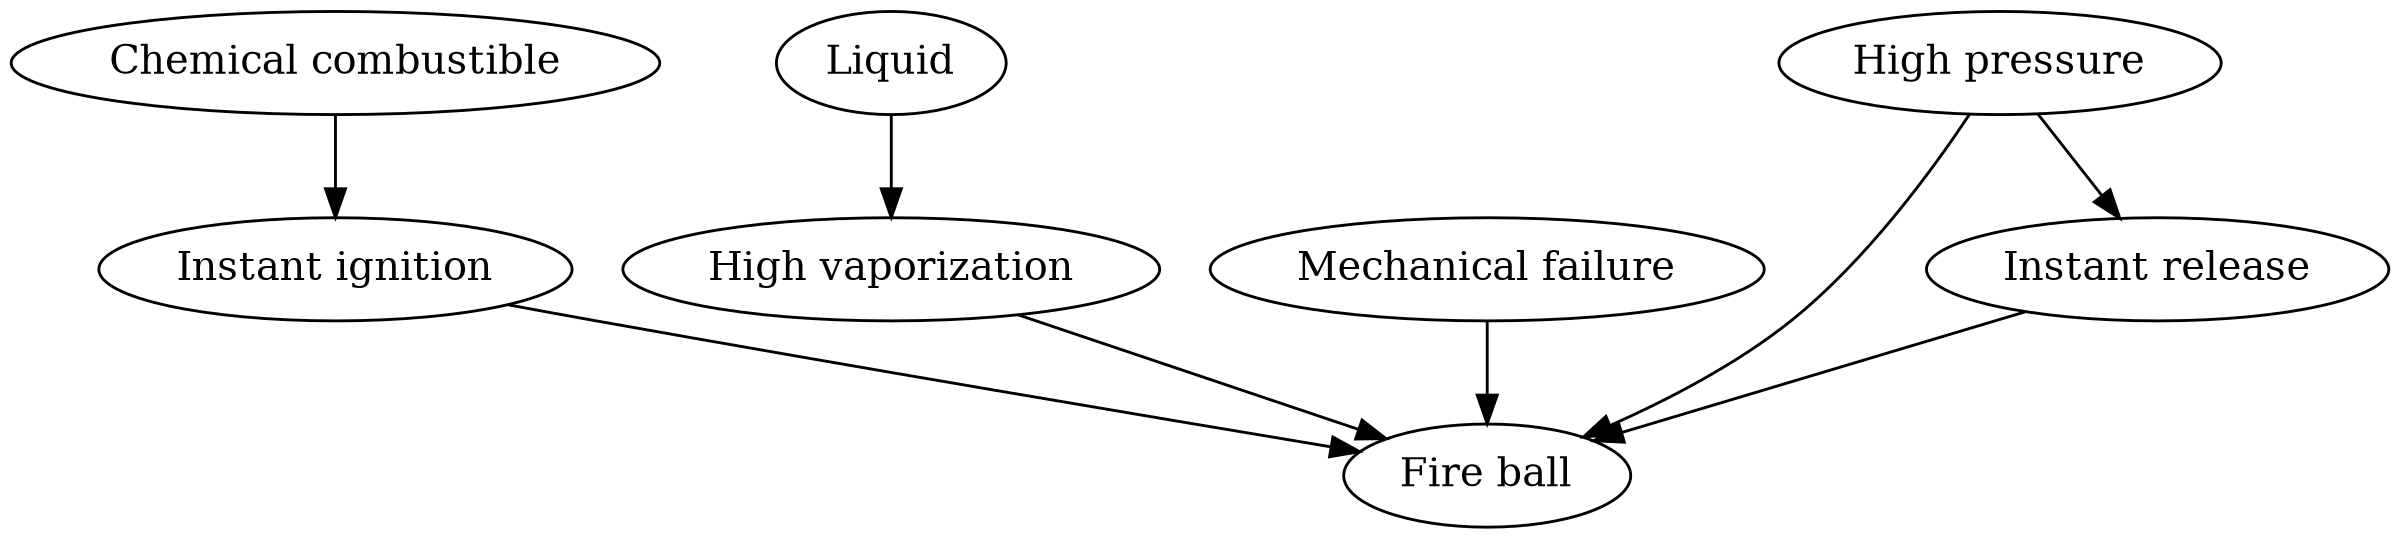

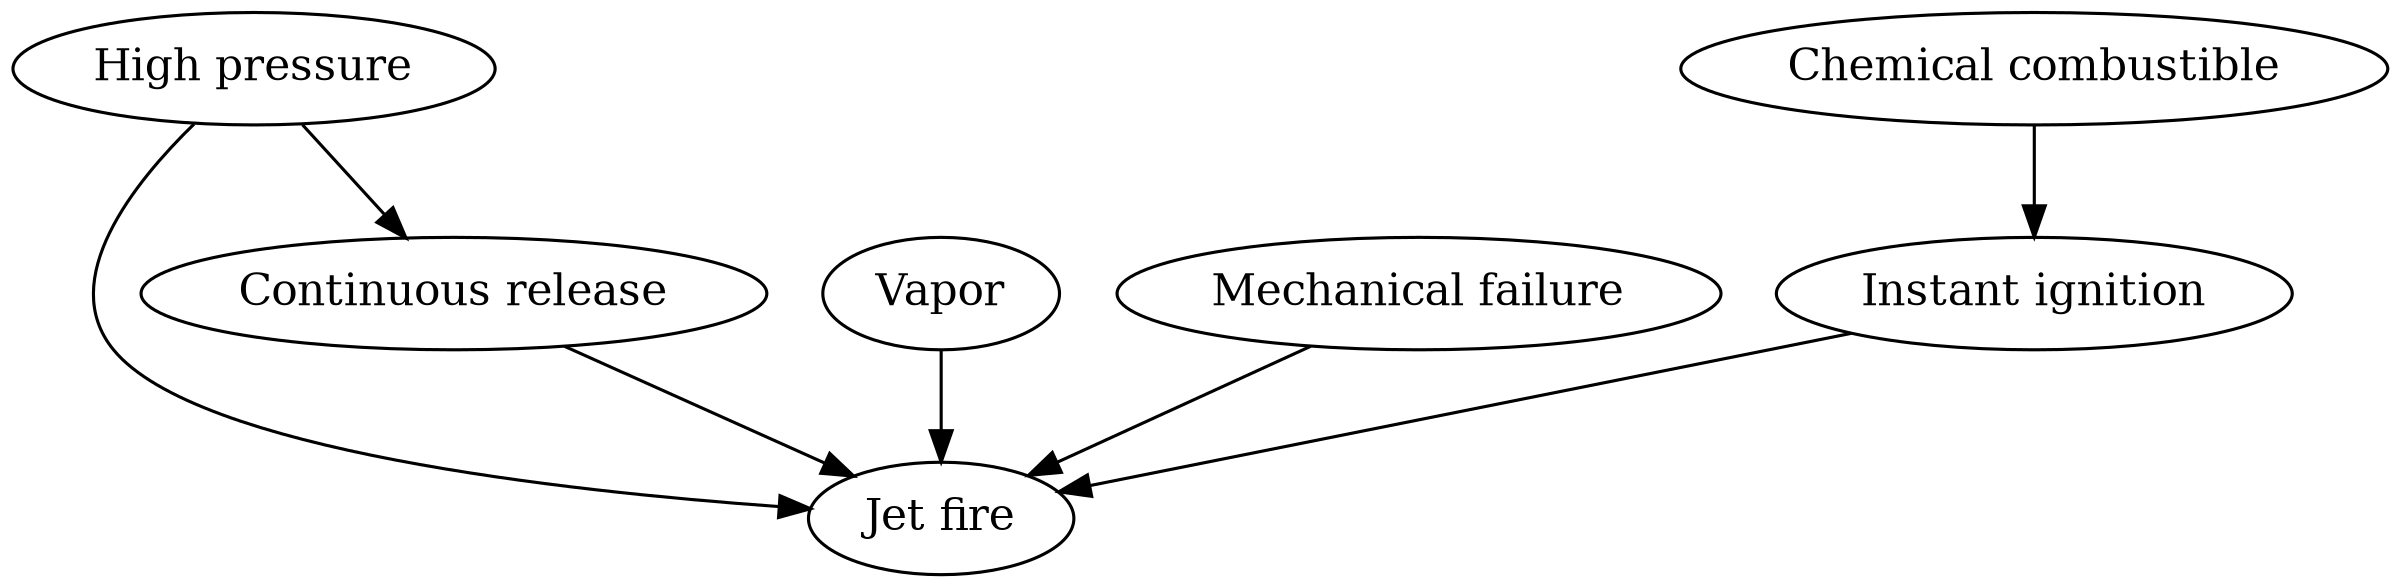

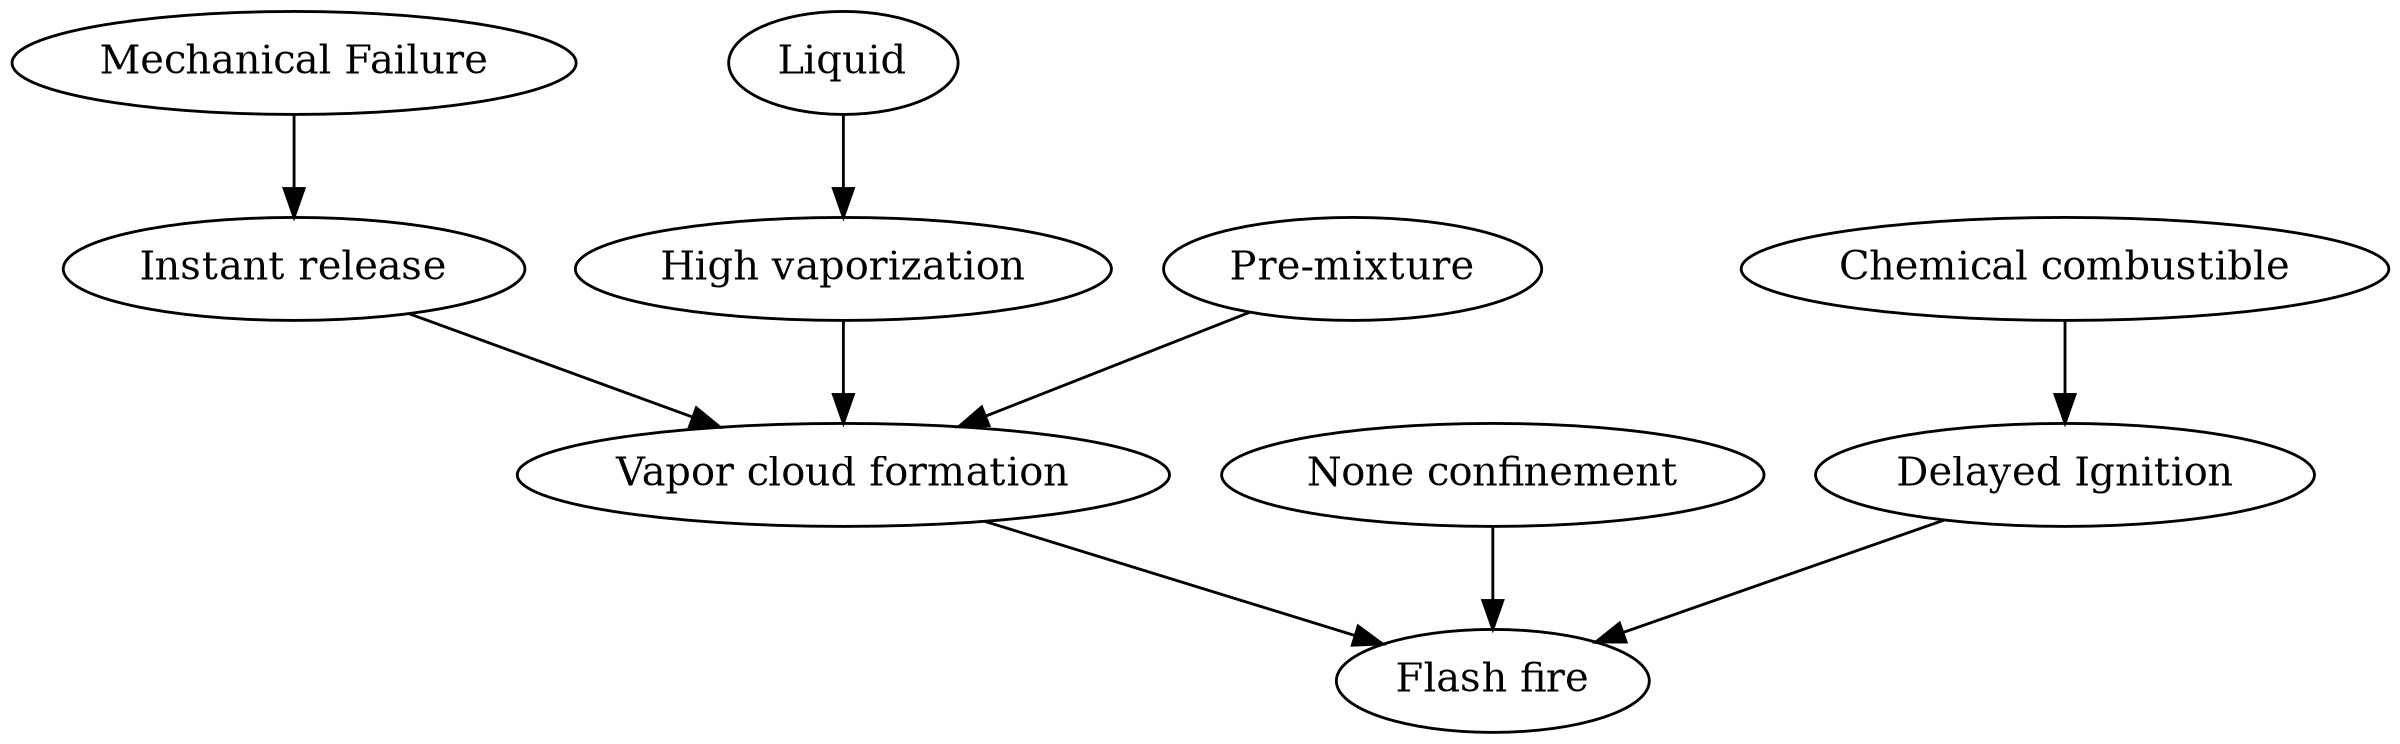

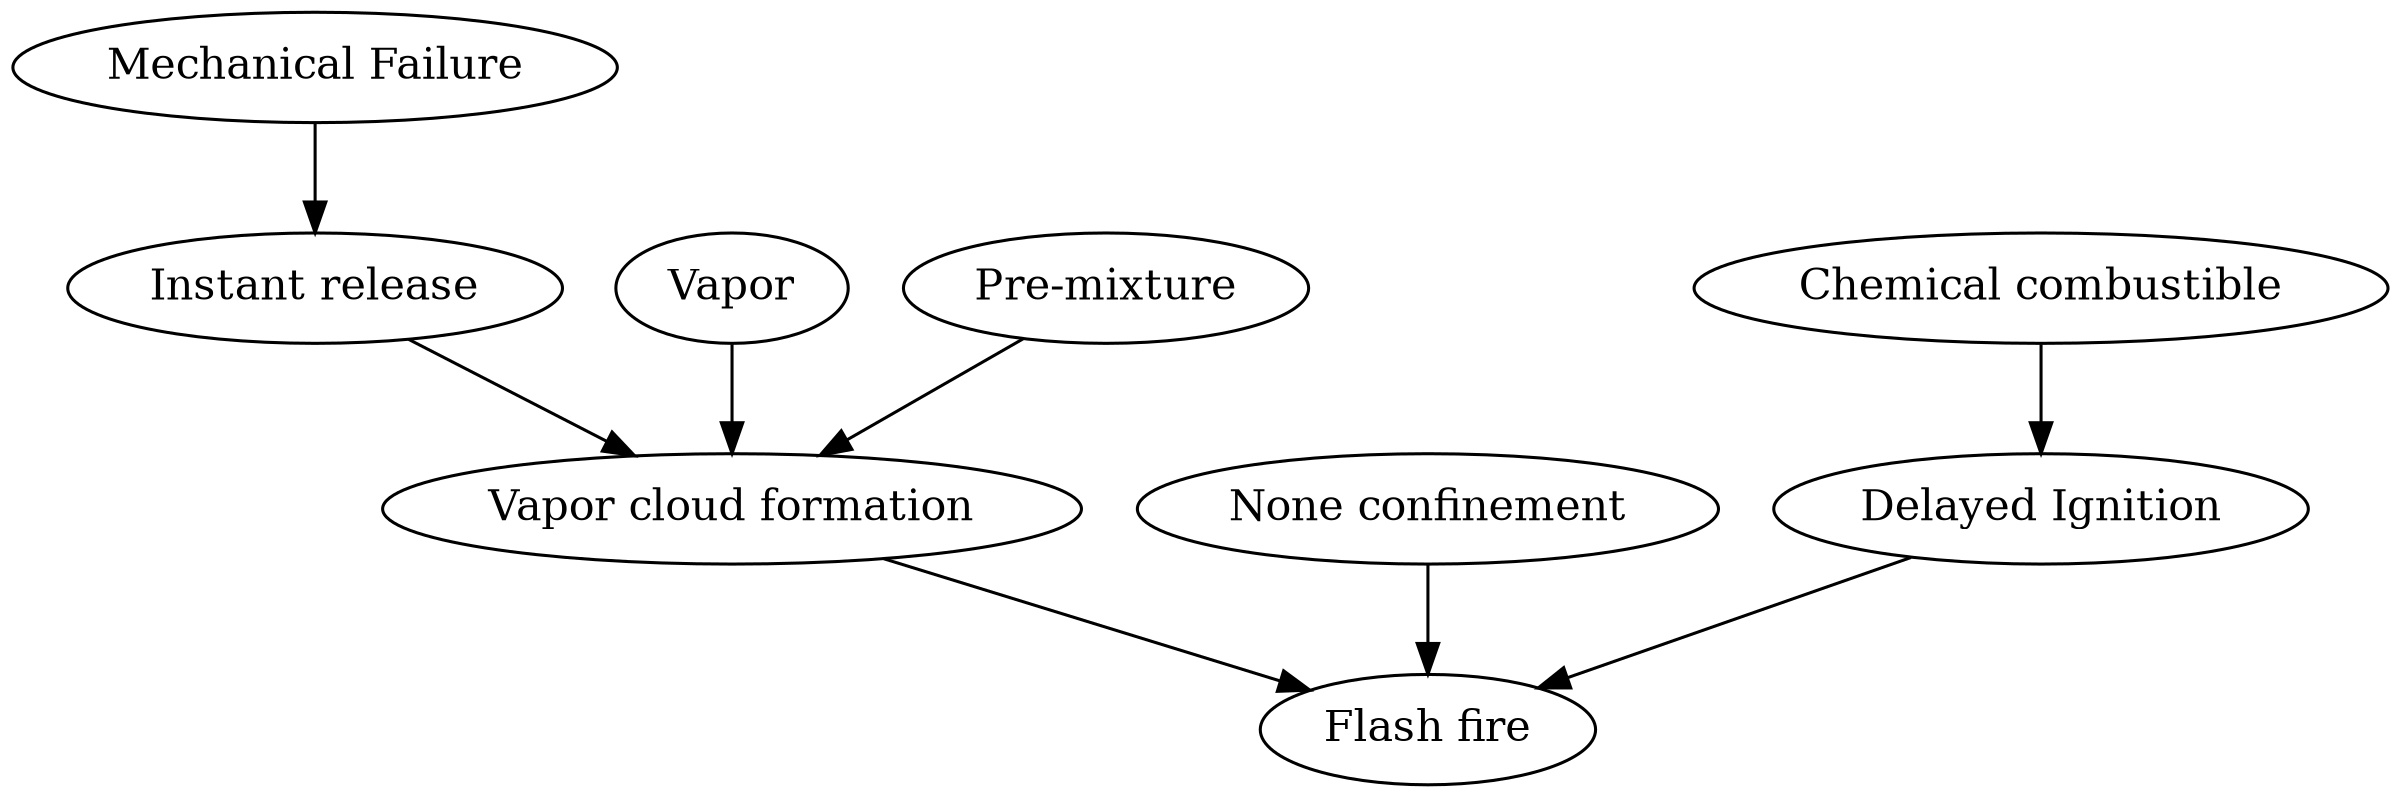

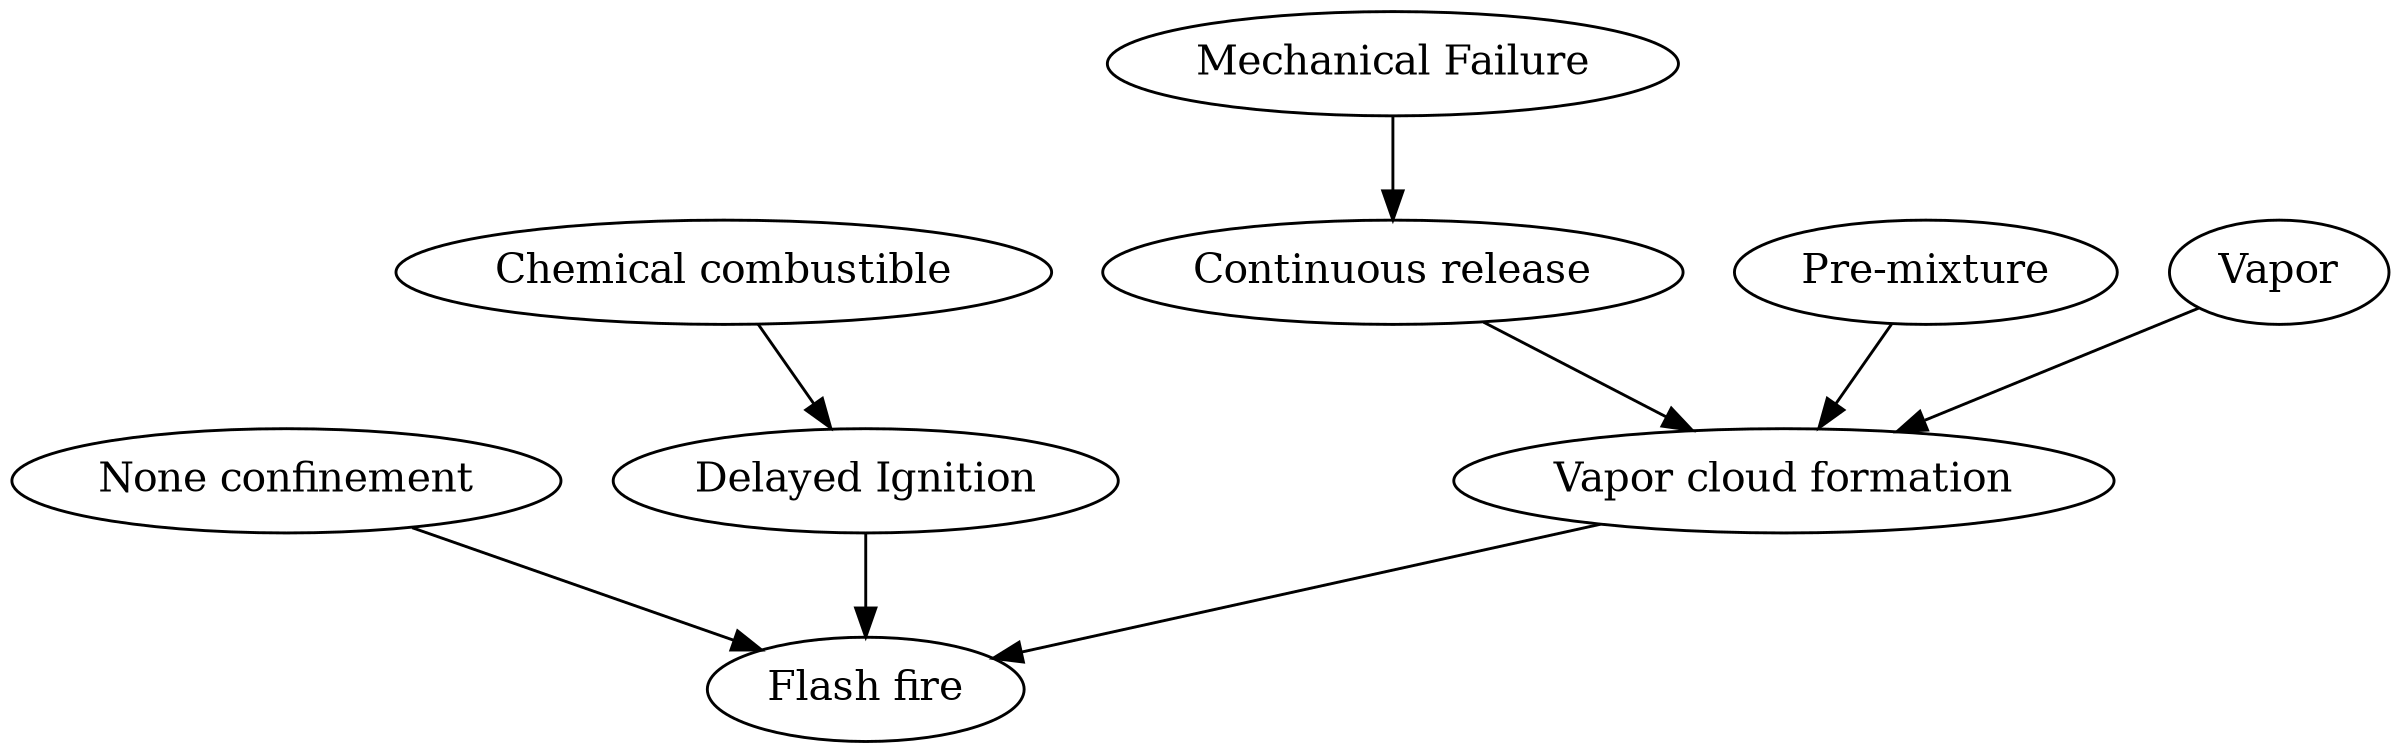

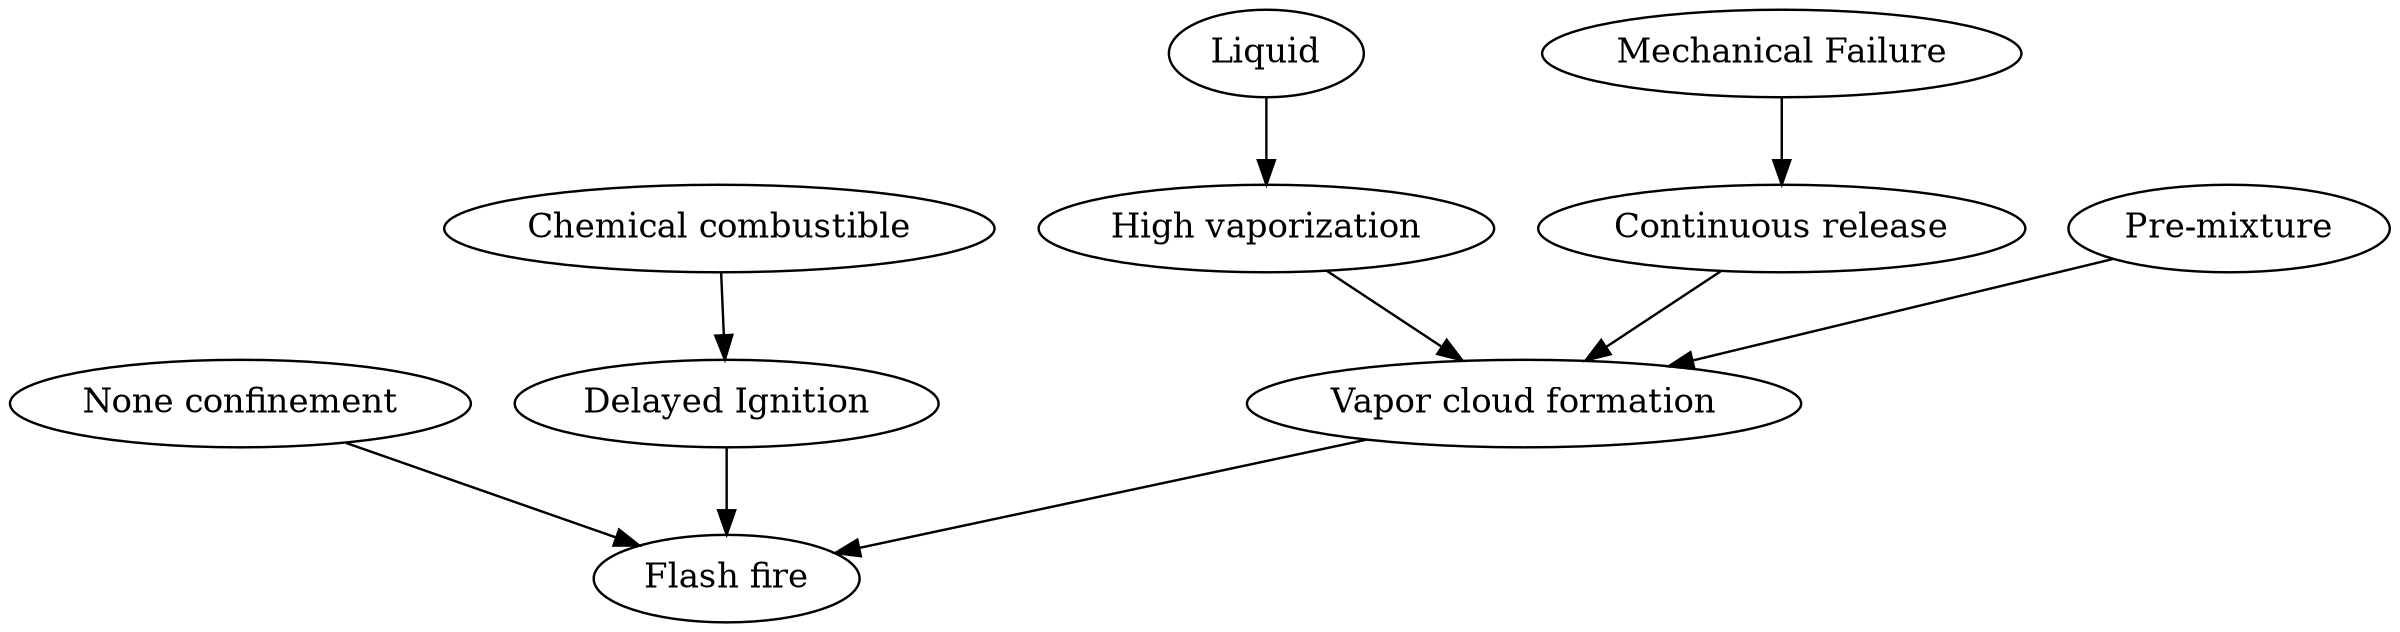

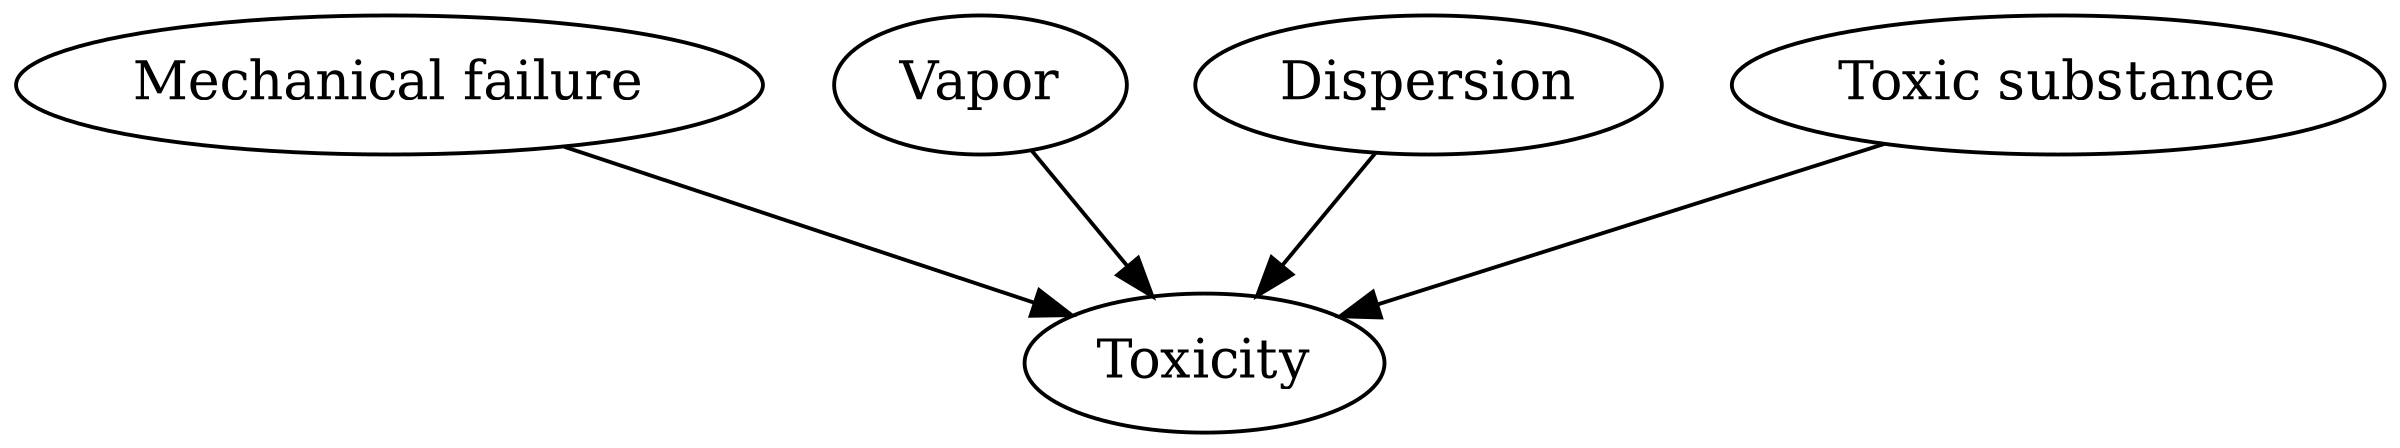

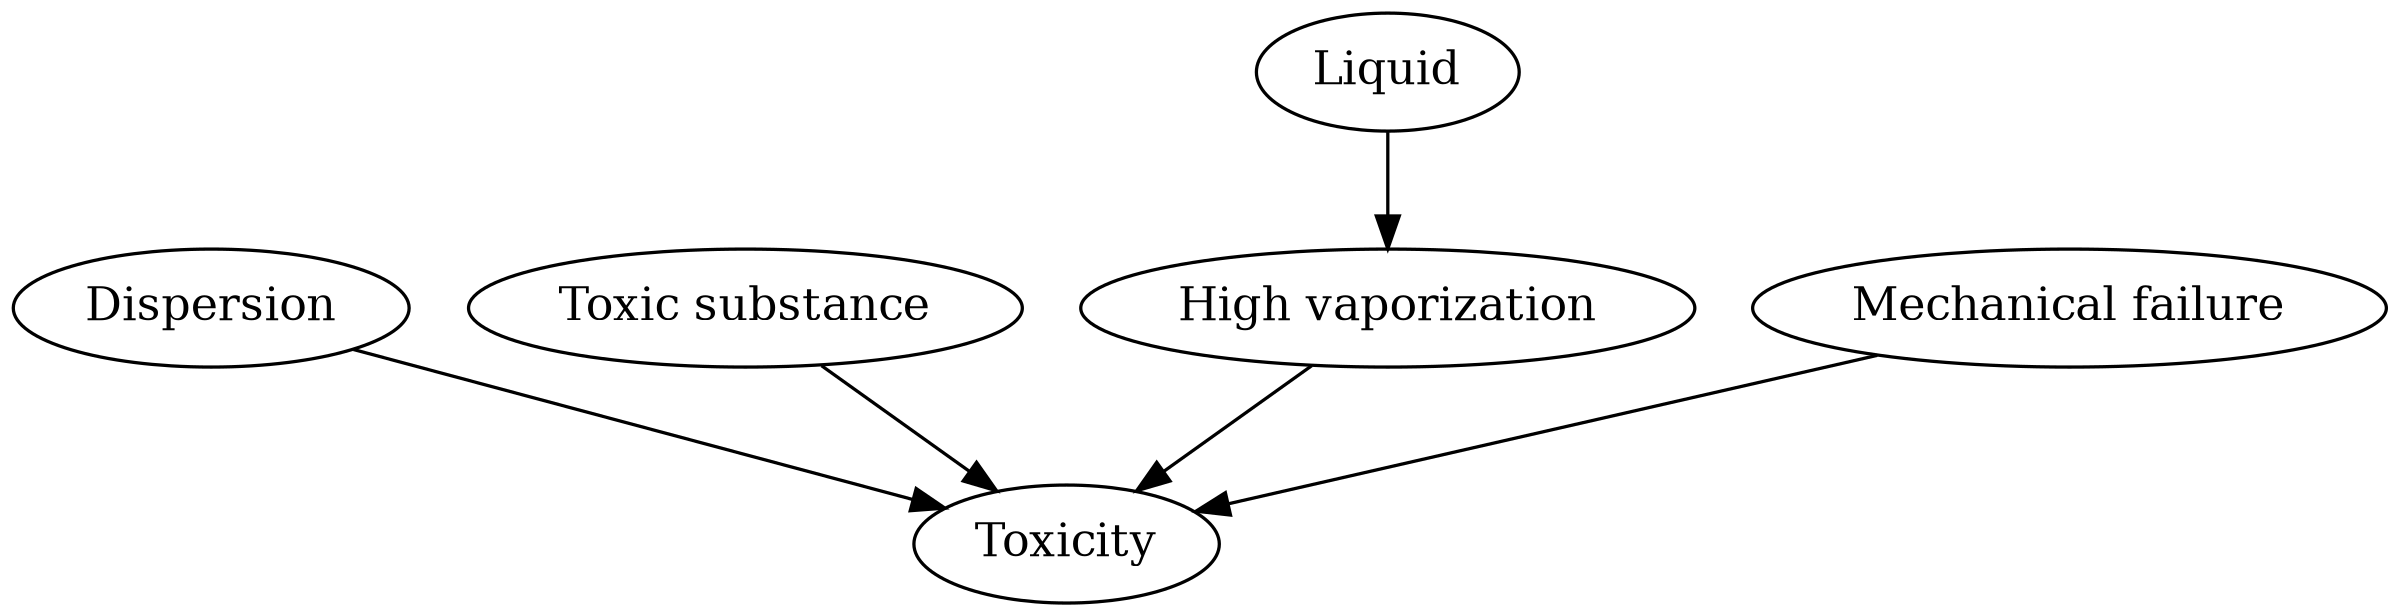

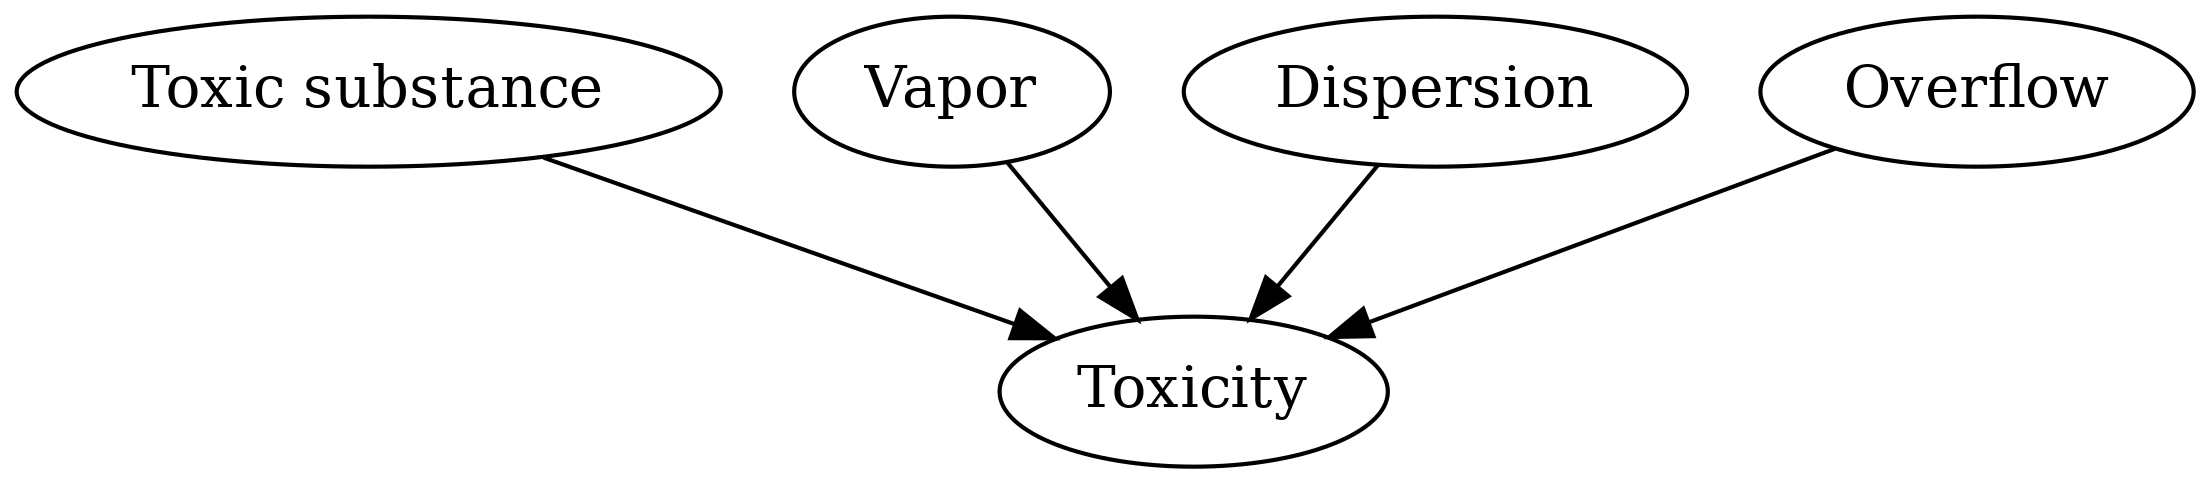

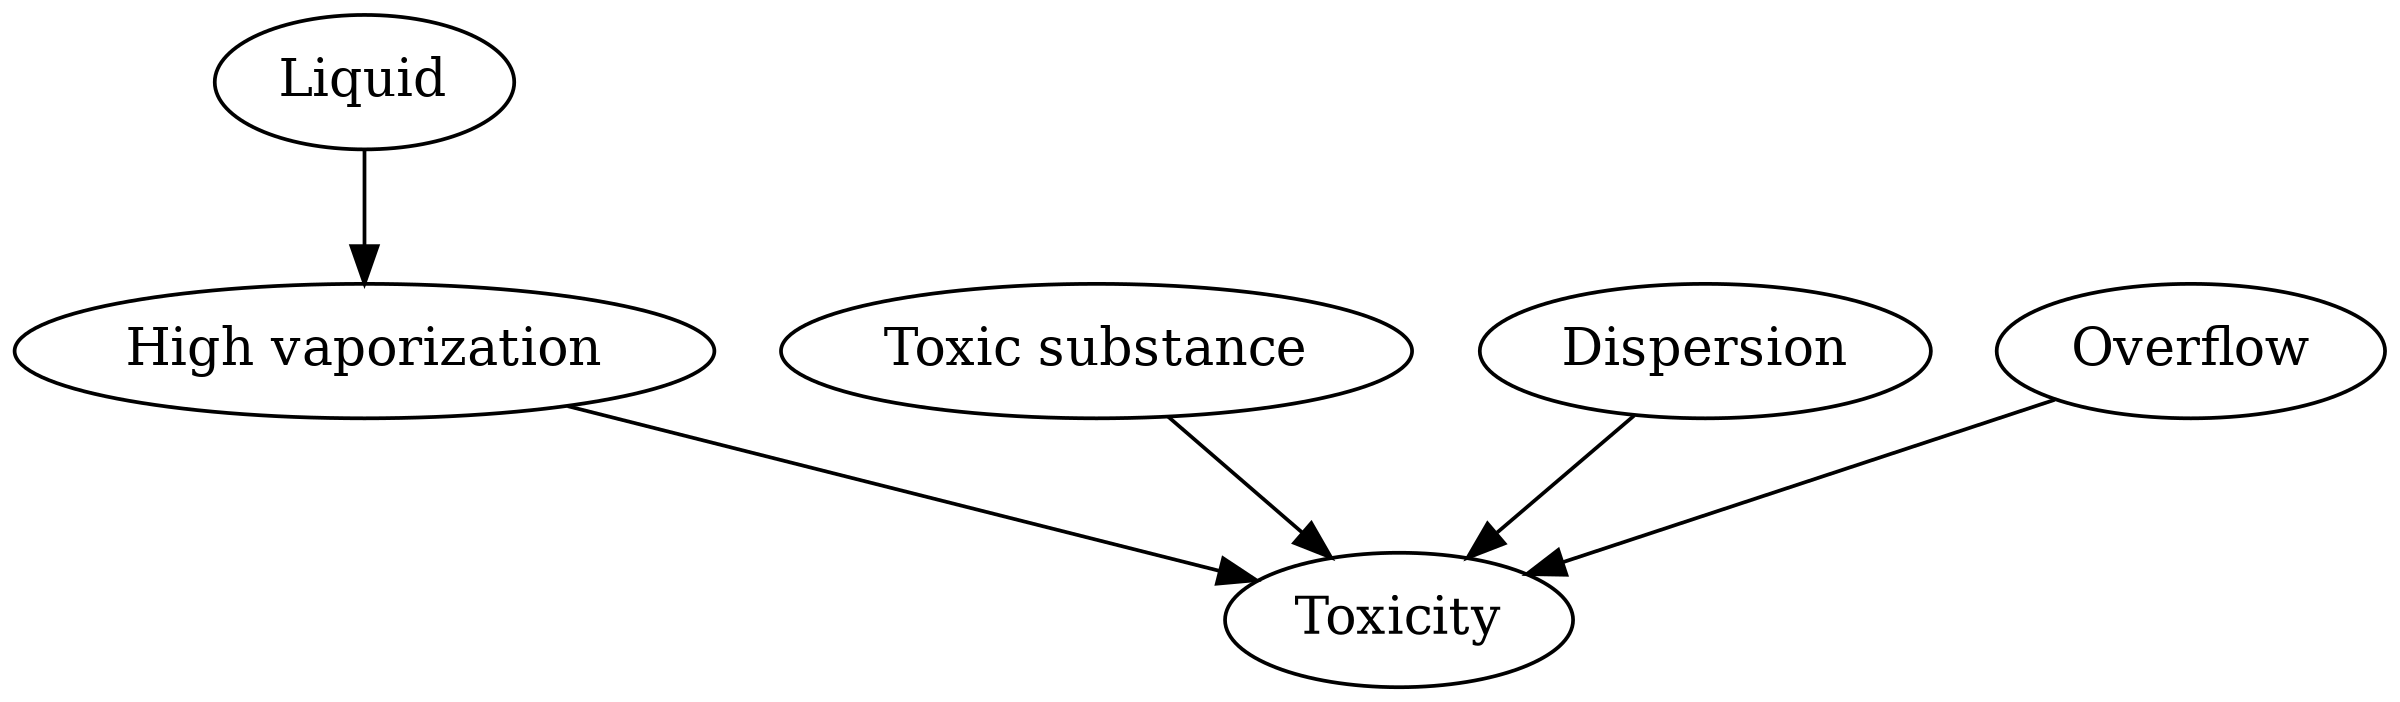

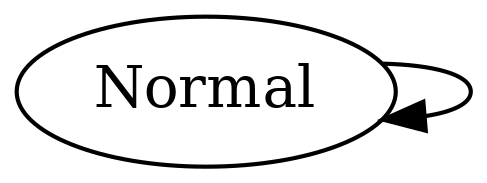

In [2]:
import networkx as nx
from graphviz import Digraph
from IPython.display import display, Image

# 读取 GraphML 文件

G = nx.read_graphml(file_path)

# 提取弱连通子图（适用于有向图）
subgraphs = [
    G.subgraph(c).copy()
    for c in nx.weakly_connected_components(G)
    if G.subgraph(c).number_of_edges() > 0
]

# 遍历每个子图并用 Graphviz 可视化（仅展示）
for i, subG in enumerate(subgraphs, start=1):
    dot = Digraph(comment=f"Explosion Graph {i}", format='png')
    dot.attr(rankdir="TB", size="8,5", dpi='300')  # 横向布局

    # 构建邻接表
    adj_list = {}
    for node in subG.nodes():
        from_label = subG.nodes[node].get("label", "").strip() or node
        neighbors = [
            subG.nodes[neighbor].get("label", "").strip() or neighbor
            for neighbor in subG.successors(node)
        ]
        if neighbors:
            adj_list[from_label] = neighbors

    # 添加节点和边
    for src, targets in adj_list.items():
        dot.node(src)
        for tgt in targets:
            dot.node(tgt)
            dot.edge(src, tgt)

    # ✅ 展示图像（不保存）
    image_data = dot.pipe(format='png')
    display(Image(image_data, format='png'))


In [3]:
import networkx as nx
import json

# 读取 GraphML 文件

G = nx.read_graphml(file_path)

# 提取弱连通子图（子图至少要有一条边）
subgraphs = [
    G.subgraph(c).copy()
    for c in nx.weakly_connected_components(G)
    if G.subgraph(c).number_of_edges() > 0
]

# 构建 JSON 数据结构
graph_data_dict = {}

for i, subG in enumerate(subgraphs, start=1):
    graph_key = f"Graph {i}"
    relation_list = []

    for node in subG.nodes():
        from_label = subG.nodes[node].get("label", "").strip() or node
        for successor in subG.successors(node):
            to_label = subG.nodes[successor].get("label", "").strip() or successor
            relation_list.append(f"{from_label} causes {to_label}")

    if relation_list:
        graph_data_dict[graph_key] = relation_list

# 保存为 JSON 文件
output_path = "data/dataset/graph_relations.json"
with open(output_path, "w", encoding="utf-8") as f:
    json.dump(graph_data_dict, f, indent=4, ensure_ascii=False)

print(f"✅ 已保存 JSON 文件：{output_path}")


✅ 已保存 JSON 文件：data/dataset/graph_relations.json


In [4]:
import json

# JSON 文件路径
json_path = r"data/dataset/graph_relations.json"

# 读取 JSON 文件
with open(json_path, "r", encoding="utf-8") as f:
    graph_data = json.load(f)

# 展示 Graph 1 的内容
graph_1 = graph_data.get("Graph 1", [])
print("✅ Graph 1 内容如下：\n")
for relation in graph_1:
    print(relation)


✅ Graph 1 内容如下：

High vaporization causes Vapor cloud formation
Pre-mixture causes Vapor cloud formation
Liquid causes High vaporization
Continuous release causes Vapor cloud formation
Vapor cloud formation causes VCE
Mechanical Failure causes Continuous release
Chemical combustible causes Delayed Ignition
High confinement causes VCE
Delayed Ignition causes VCE


In [ ]:
import json

# 原始文件路径
input_path = r"data/dataset/graph_relations.json"
# 新结构文件保存路径
output_path = r"data/dataset/graph_relations_labeled_structured.json"

# 读取原始 JSON 文件
with open(input_path, "r", encoding="utf-8") as f:
    graph_data = json.load(f)

# 图重命名 & 标签识别函数
def rename_graph_if_vce_condition_met(graph_data_dict):
    updated_list = []

    for graph_name, relations in graph_data_dict.items():
        all_text = " ".join(relations).lower()

        has_vce = any("vce" in r.lower() for r in relations)
        has_dust = any("dust explosion" in r.lower() for r in relations)
        has_bleve = any("bleve" in r.lower() for r in relations)

        has_vapor = bool(re.search(r"\bvapor\b", all_text))
        has_instant_release = "instant release" in all_text
        has_continuous_release = "continuous release" in all_text
        has_liquid = "liquid" in all_text
        has_pool_fire = "pool fire" in all_text
        has_overflow = "overflow" in all_text
        has_mechanical_failure = "mechanical failure" in all_text
        has_jet_fire = "jet fire" in all_text
        has_fire_ball = "fire ball" in all_text
        has_flash_fire = "flash fire" in all_text
        has_toxicity = "toxicity" in all_text
        has_normal = any("normal" in r.lower() for r in relations)
########explosion
        if has_vce and has_liquid and has_instant_release:
            hazard_label = "VCE_liquid_instant"
        elif has_vce and has_liquid and has_continuous_release:
            hazard_label = "VCE_liquid_continuous"
        elif has_vce and has_vapor and has_instant_release:
            hazard_label = "VCE_vapor_instant"
        elif has_vce and has_vapor and has_continuous_release:
            hazard_label = "VCE_vapor_continuous"
        elif has_dust:
            hazard_label = "Dust_explosion"
        elif has_bleve:
            hazard_label = "BLEVE"
########fire
        elif has_overflow and has_pool_fire:
            hazard_label = "Pool_fire_overflow"
        elif has_mechanical_failure and has_pool_fire:
            hazard_label = "Pool_fire_mechanical_failure"
        elif has_jet_fire and has_liquid:
            hazard_label = "jet_fire_liquid"
        elif has_jet_fire and has_vapor:
            hazard_label = "jet_fire_vapor"
        elif has_fire_ball:
            hazard_label = "fire_ball"
        elif has_flash_fire and has_liquid:
            hazard_label = "flash_fire_liquid"
        elif has_flash_fire and has_vapor:
            hazard_label = "flash_fire_vapor"
        elif has_toxicity and has_vapor and has_mechanical_failure:
            hazard_label = "toxicity_vapor_mechanical_failure"
        elif has_toxicity and has_liquid and has_mechanical_failure:
            hazard_label = "toxicity_liquid_mechanical_failure"
        elif has_toxicity and has_vapor and has_overflow:
            hazard_label = "toxicity_vapor_overflow"
        elif has_toxicity and has_liquid and has_overflow:
            hazard_label = "toxicity_liquid_overflow"

        elif has_normal:
            hazard_label = "Normal"
        else:
            hazard_label = graph_name  # fallback

        updated_list.append({
            "Hazard": hazard_label,
            "Scenarios": relations
        })

    return updated_list

structured_output = rename_graph_if_vce_condition_met(graph_data)

with open(output_path, "w", encoding="utf-8") as f:
    json.dump(structured_output, f, indent=4, ensure_ascii=False)

print(f"✅ saved as JSON file：{output_path}")


✅ 已保存为结构化 JSON 文件：data/dataset/graph_relations_labeled_structured.json
